In [2]:
# coding: utf-8
# 2015.09.24  MaxLFQ UPS dataset
from __future__ import division
import pandas, numpy, itertools, os, csv, re
import pyteomics.mass as pmass
import scipy.stats as ss
import scipy.optimize as so
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from cStringIO import StringIO
from sklearn.neighbors import KNeighborsRegressor

get_ipython().magic(u'matplotlib inline')
pylab.rcParams['figure.figsize'] = (8.0, 8.0)
isomass = pmass.nist_mass['C'][13][0] - 12.0

consensus_txt = r'd:\MaxLFQ_UPS\Analysis\Quant\003-TextExporter-out\20130510_EXQ1_IgPa_QC_UPS1_01.csv'
eic_txt = r'd:\MaxLFQ_UPS\Analysis\Quant\007-EICExtractor-out\20130510_EXQ1_IgPa_QC_UPS1_01.csv'

In [3]:
num_samples = 2
num_replica = 4

In [3]:
def read_consensus(fn):
    '''
    Read text export (.tab) from consensusXML generated by OpenMS
    '''
    rd = csv.reader(open(fn), delimiter='\t')
    consHeader = []
    peptHeader = []
    runsName = []

    for row in rd:
        if row[0] == '#CONSENSUS':
            consHeader = row
        elif row[0] == '#UNASSIGNEDPEPTIDE':
            peptHeader = row
        elif row[0] == 'MAP':
            runsName.append(row[2])

    s = StringIO()
    with open(fn) as fh:
        for line in fh:
            if line.startswith("CONSENSUS"):
                s.write(line)
    s.seek(0)
    cons = pandas.read_csv(s, sep='\t', header=None, names=consHeader)
    
    coPeps = []
    with open(fn) as fh:
        for line in fh:
            if line.startswith("CONSENSUS"):
                coPeps.append('')
            elif line.startswith('PEPTIDE') and coPeps[-1] == '':
                coPeps[-1] = line.split("\t")[5]
    
    cons['peptide_0'] = coPeps
    
    s = StringIO()
    with open(fn) as fh:
        for line in fh:
            if line.startswith("UNASSIGNEDPEPTIDE"):
                s.write(line)
    s.seek(0)
    uaPeps = pandas.read_csv(s, sep='\t', header=None, names=peptHeader)
    uaPeps = uaPeps.groupby(['sequence', 'charge']).mean()
    return cons, uaPeps, runsName

In [4]:
def read_eic(fn):
    '''
    Read the detailed output files from EIC extraction in OpenMS.
    Two isotopic peaks were extracted for each consensus feature and unassigned peptide ID. 
    Calculate geometric average of intensities from two isotopic peaks, RT and mass difference
    '''
    
    with open(fn) as fh:
        eic_str = [StringIO(),StringIO(),StringIO(),StringIO()]
        sampHeader = [i for i in fh.next().rstrip().split(',') if i]
        fh.next()
        cols = fh.next().rstrip().split(',')
        for ix in range(2, len(cols)):
            i = int((ix-2)/5)
            cols[ix] = '_'.join([sampHeader[i], cols[ix]])
        
        ix = 0
        for line in fh:
            eic_str[ix % 4].write(line)
            ix += 1

        [s.seek(0) for s in eic_str]
    

    eic = pandas.read_csv(eic_str[0], header=None, names=cols)
    eic_iso = pandas.read_csv(eic_str[1], header=None, names=cols)
    eic_decoy0 = pandas.read_csv(eic_str[2], header=None, names=cols)
    eic_decoy1 = pandas.read_csv(eic_str[3], header=None, names=cols)
    
    for samp in sampHeader:
        intIx = samp + '_intensity'
        rtIx = samp + '_dRT'
        ppmIx = samp + '_dppm'

        eic[samp + '_int_1'] = (eic[intIx] * eic_iso[intIx]) ** 0.5
        eic[samp + '_dRT_1'] = eic[rtIx] - eic_iso[rtIx]
        eic[samp + '_ppm_1'] = eic[ppmIx] - eic_iso[ppmIx]

        eic[samp + '_int_d1'] = (eic_decoy0[intIx] * eic_decoy1[intIx]) ** 0.5
        eic[samp + '_dRT_d0'] = eic_decoy0[rtIx] 
        eic[samp + '_dRT_d1'] = eic_decoy0[rtIx] - eic_decoy1[rtIx]
        eic[samp + '_ppm_d0'] = eic_decoy0[ppmIx]
        eic[samp + '_ppm_d1'] = eic_decoy0[ppmIx] - eic_decoy1[ppmIx]

    return eic

In [5]:
eic = read_eic(eic_txt)
cons, uapep, ic0 = read_consensus(consensus_txt)

icols = [i for i in cons.columns if i.startswith('intensity_')]
cons = cons[icols + ['quality_cf', 'peptide_0', 'charge_cf', 'rt_cf', 'mz_cf']]
cons.rename(columns=dict(zip(icols[1:], ic0)), inplace=True)


ic1x = [i for i in eic.columns if i.endswith('int_1')]
crt0 = [i for i in eic.columns if i.endswith('dRT')]
crt1 = [i for i in eic.columns if i.endswith('dRT_1')]
cppm0 = [i for i in eic.columns if i.endswith('ppm')]
cppm1 = [i for i in eic.columns if i.endswith('ppm_1')]


dic1x = [i for i in eic.columns if i.endswith('int_d1')]
drt0 = [i for i in eic.columns if i.endswith('dRT_d0')]
drt1 = [i for i in eic.columns if i.endswith('dRT_d1')]
dppm0 = [i for i in eic.columns if i.endswith('ppm_d0')]
dppm1 = [i for i in eic.columns if i.endswith('ppm_d1')]

In [6]:
dx = pandas.concat([eic, cons], axis=1)
dx['peptide_0'] = [i for i in cons.peptide_0]  + [ i[0] for i in uapep.index.tolist()]
dx['charge_cf'] = [i for i in cons.charge_cf]  + [ i[1] for i in uapep.index.tolist()]
dx['mz_cf'] = [i for i in cons.mz_cf] + uapep.mz.tolist()
dx['rt_cf'] = [i for i in cons.rt_cf] + uapep.rt.tolist()
dx = dx[dx.rt_cf > 0]


dx['peptide'] = [ re.sub('C\(Carbamidomethyl\)', 'C', str(i)) for i in dx.peptide_0]
dx['BaseSeq'] = [ re.sub('\(.+?\)', '', str(i)) for i in dx.peptide_0]

dx['mods'] = [ sorted(re.findall('\(.+?\)', str(i))) for i in dx.peptide ]
dx['uniq'] = [ "%s%d%s" % (x.BaseSeq, x.charge_cf, ''.join(x.mods)) for i, x in dx.iterrows()]

dx['f_overlap'] = [ numpy.count_nonzero(numpy.nan_to_num(i)) for i in dx[ic0].values ]
dx['e_overlap'] = [ numpy.count_nonzero(i) for i in dx[ic1x].values ]
dx['medianEIC'] = dx[ic1x].median(axis=1)


print len(dx), len(ic1x)

162141 8


In [8]:
e = numpy.array(dx[dx.intensity_cf.isnull() == False].e_overlap).tolist()
print e.count(len(ic0)) / len(e), len(e)

0.744526435907 131450


In [9]:
# Reference set: No missing value in consensus features and extracted peaks
refdx = dx[(dx.f_overlap ==len(ic0)) & (dx.e_overlap == len(ic0))]

fcol = numpy.concatenate([crt0, crt1, cppm0, cppm1])
dcol = numpy.concatenate([drt0, drt1, dppm0, dppm1])

refz = (refdx[fcol] - refdx[fcol].mean()) / refdx[fcol].std()
decoyz = (refdx[dcol] - refdx[fcol].mean().values) / refdx[fcol].std().values
testz = (dx[fcol] - refdx[fcol].mean()) / refdx[fcol].std()

for i in numpy.array(ic1x).reshape(num_samples, num_replica):
    cv = refdx[i].std(axis=1) / refdx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for ii in i:
        refz[ii + '_cv'] = cv
    
for i in numpy.array(dic1x).reshape(num_samples, num_replica):    
    cv = refdx[i].std(axis=1) / refdx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for ii in i:
        decoyz[ii + '_cv'] = cv

for i in numpy.array(ic1x).reshape(num_samples, num_replica):
    cv = dx[i].std(axis=1) / dx[i].mean(axis=1)
    cv = numpy.sqrt(cv)
    for ii in i:
        testz[ii + '_cv'] = cv    
        
ccv = [i for i in refz.columns if i.endswith('cv')]
dcv = [i for i in decoyz.columns if i.endswith('cv')]

In [54]:
print refdx[cppm0].mean()
print refdx[cppm0].std()

20130510_EXQ1_IgPa_QC_UPS1_01.mzML_dppm   -0.383258
20130510_EXQ1_IgPa_QC_UPS1_02.mzML_dppm   -1.042725
20130510_EXQ1_IgPa_QC_UPS1_03.mzML_dppm    1.814995
20130510_EXQ1_IgPa_QC_UPS1_04.mzML_dppm    0.700630
20130510_EXQ1_IgPa_QC_UPS2_01.mzML_dppm   -0.655508
20130510_EXQ1_IgPa_QC_UPS2_02.mzML_dppm    1.076950
20130510_EXQ1_IgPa_QC_UPS2_03.mzML_dppm    0.249635
20130510_EXQ1_IgPa_QC_UPS2_04.mzML_dppm    1.309338
dtype: float64
20130510_EXQ1_IgPa_QC_UPS1_01.mzML_dppm    1.434273
20130510_EXQ1_IgPa_QC_UPS1_02.mzML_dppm    1.247377
20130510_EXQ1_IgPa_QC_UPS1_03.mzML_dppm    1.225166
20130510_EXQ1_IgPa_QC_UPS1_04.mzML_dppm    1.138354
20130510_EXQ1_IgPa_QC_UPS2_01.mzML_dppm    1.234505
20130510_EXQ1_IgPa_QC_UPS2_02.mzML_dppm    1.258903
20130510_EXQ1_IgPa_QC_UPS2_03.mzML_dppm    1.291767
20130510_EXQ1_IgPa_QC_UPS2_04.mzML_dppm    1.120200
dtype: float64


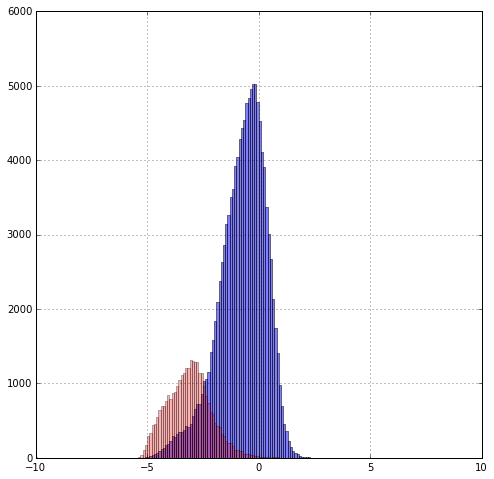

In [11]:
filCols = zip(ic1x, crt0, crt1, cppm0, cppm1, ccv)
filCols_decoy = zip(dic1x, drt0, drt1, dppm0, dppm1, dcv)

zscores = []
for f in filCols:
    e = refdx[f[0]] > 0
    rz = refz[e]
    z = [numpy.sum(v*v) for v in rz[list(f[1:])].values]
    zscores = zscores + z
pandas.Series(-numpy.log(zscores)).hist(bins=numpy.arange(-10,10,0.1), alpha = 0.5, color = 'b')
scoredist = ss.lognorm.fit(pandas.Series(zscores).fillna(value=0))

dzscores = []
for f in filCols_decoy:
    e = refdx[f[0]] > 0
    dd = decoyz[e]
    z = [numpy.sum(v*v) for v in dd[list(f[1:])].values]

    dzscores = dzscores + z
pandas.Series(-numpy.log(dzscores)).hist(bins=numpy.arange(-10,10,0.1), alpha = 0.3, color='r')

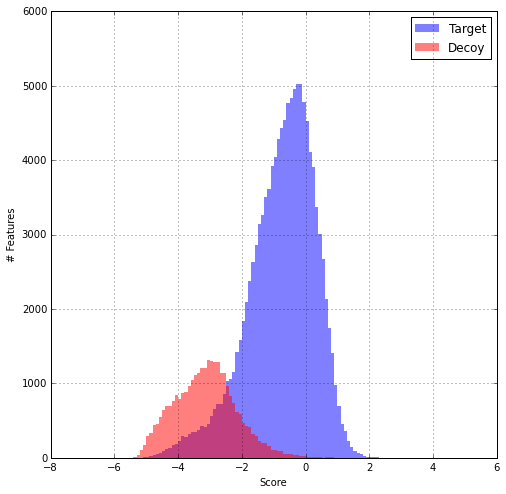

In [12]:
bins = numpy.arange(-6.6, 4.5, 0.1)
pandas.Series(-numpy.log(zscores)).hist(bins=bins, alpha = 0.5, color ='b', lw=0, label='Target')
pandas.Series(-numpy.log(dzscores)).hist(bins=bins, alpha = 0.5, color='r', lw=0, label='Decoy')
# pandas.Series(-numpy.log(tzscores)).hist(bins=bins, alpha = 0.3, color='y', lw=0, label='All')
plt.legend()
plt.xlabel('Score')
plt.ylabel('# Features')

In [13]:
score_list = sorted(zip(zscores + dzscores, [0 for i in zscores] + [1 for i in zscores]), key=lambda x: x[0])
score_cutoff = 0
hit_count = 0
decoy_count = 0
fdr = 0.01
for s in score_list:
    hit_count += 1
    score_cutoff = s[0]
    if s[1] > 0:
        decoy_count += 1
    if decoy_count / hit_count >= fdr:
        print score_cutoff
        break

3.16438676413


10158 15010 0.676748834111
10469 15010 0.69746835443
10404 15010 0.693137908061
10525 15010 0.701199200533
10380 15010 0.691538974017
9988 15010 0.665423051299
10316 15010 0.6872751499
10263 15010 0.683744170553
108 3556 0.0303712035996
81 3609 0.0224438902743
100 3976 0.0251509054326
74 3786 0.0195456946646
99 3583 0.0276304772537
114 3716 0.0306781485468
148 3846 0.0384815392616
109 3835 0.0284224250326


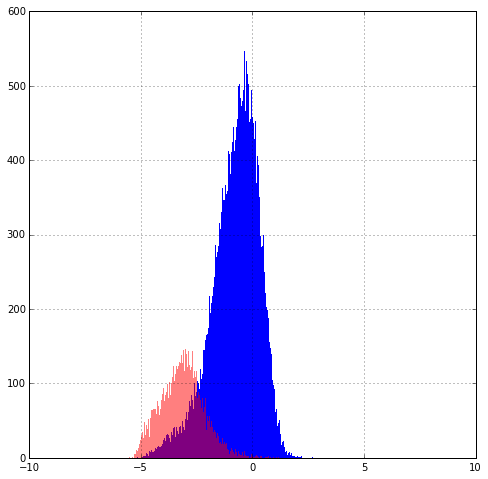

In [14]:
target_score = []
for f in filCols:
    eic = refdx[f[0]] > 0
    tdata = refz[eic]
    score = [numpy.sum(v*v) for v in tdata[list(f[1:])].values]
    target_score = target_score + score
    score = numpy.array(score)
    print list(score < score_cutoff).count(True) , len(score), list(score < score_cutoff).count(True) / len(score)
pandas.Series(-numpy.log(target_score)).hist(bins=numpy.arange(-10,10,0.01), lw=0)

null_score = []
for f in filCols_decoy:
    ddata = decoyz[refdx[f[0]] > 0]
    score = [numpy.sum(v*v) for v in ddata[list(f[1:])].values]
    null_score = null_score + score
    score = numpy.array(score)
    print list(score < score_cutoff).count(True) , len(score), list(score < score_cutoff).count(True) / len(score)

pandas.Series(-numpy.log(null_score)).hist(bins=numpy.arange(-10,10,0.01), lw=0, color='r', alpha=0.5)

In [15]:
for f in filCols:
    score = numpy.array([numpy.sum(v*v) for v in testz[list(f[1:])].values])
    print list(score < score_cutoff).count(True) / len(score)
    dx[f[0]][list(score > score_cutoff )] = 0

0.278948569455
0.295995460741
0.25598707298
0.311660838406
0.293374285344
0.26150079252
0.302267779279
0.250664545056


C:\Users\ZHANGBO\AppData\Local\Enthought\Canopy\User\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
dx['medianEIC'] = dx[ic1x].median(axis=1)
dx['e_overlap'] = [ numpy.count_nonzero(i) for i in dx[ic1x].values ]

# quantified at least in one run in each sample
# ix = numpy.min([numpy.mean(dx[i].values, axis=1) for i in numpy.array(ic1x).reshape(num_samples, num_replica)], axis=0) > 0 

# or quantified at least in half of samples
ix = dx.e_overlap > 0.5 * num_samples * num_replica

# dx: missing value filtered dataframe
dx = dx[ix]
print len(dx), len(dx.BaseSeq.unique())
print list((dx.peptide_0 == '') & (dx.intensity_cf > 0)).count(False)
list((dx.peptide_0 == '') & (dx.intensity_cf > 0)).__len__()

59827 15220
23395


59827

In [17]:
def mediancurve(dat, rcol, scol, knn=15, span=500):
    '''
    Predict median shift (fold-change) of ion intensity at a given RT, using KNN regression
    rcol: column of global medians
    scol: columm of extracted intensities of one sample
    knn:  number of k nearest neighbors  
    span: number of features for median shift calculation. 
    '''
    
    d = dat[(dat[scol] > 0) & (dat[rcol] > 0)].sort(columns=['rt_cf'])
    
    x = d['rt_cf'].values
    y = numpy.log2(d[scol] / d[rcol]) # fold-change

    X = numpy.array([numpy.mean(x[i:i+span]) for i in range(0, len(x), int(span/10))])
    y = numpy.array([numpy.median(y[i:i+span]) for i in range(0, len(x),int(span/10))])
    reg = KNeighborsRegressor(n_neighbors=knn)
    reg.fit(numpy.matrix(X).T, numpy.matrix(y).T)
    return reg, X, y

In [18]:
icols = zip(ic0, ic1x)
for a in icols[:]:
    do = dx[pandas.notnull(dx[a[0]])]
    do = do[do[a[1]] > 0]
    xy = do[list(a)].apply(numpy.log2).values
    r2 = ss.pearsonr(xy[:,0], xy[:, 1])[0] ** 2
    print a[1], len(xy), r2
    if r2 < 0.5:
        icols.remove(a) # Problematic RT align, remove.

20130510_EXQ1_IgPa_QC_UPS1_01.mzML_int_1 21717 0.709298519196
20130510_EXQ1_IgPa_QC_UPS1_02.mzML_int_1 26237 0.771497958991
20130510_EXQ1_IgPa_QC_UPS1_03.mzML_int_1 22030 0.787828042298
20130510_EXQ1_IgPa_QC_UPS1_04.mzML_int_1 29180 0.816496607337
20130510_EXQ1_IgPa_QC_UPS2_01.mzML_int_1 28149 0.784613782217
20130510_EXQ1_IgPa_QC_UPS2_02.mzML_int_1 21885 0.749250281197
20130510_EXQ1_IgPa_QC_UPS2_03.mzML_int_1 22620 0.747996257083
20130510_EXQ1_IgPa_QC_UPS2_04.mzML_int_1 22806 0.779135763349


In [20]:
data = dx[ic0 + ic1x].apply(numpy.log2)
# log2 transform of selecting colums from dataframe

# data[data==-numpy.inf] = data[data!=-numpy.inf][ic1x].min().min()
data[data==-numpy.inf] = 0

data['rt'] = dx['rt_cf']
data['mass'] = dx['mz_cf'] * dx['charge_cf']
data['charge'] = dx['charge_cf']
data['peptide'] = dx.peptide
data['BaseSeq'] = dx.BaseSeq
data['uniq'] = dx.uniq 

for a, b in icols:
    dn = data[(data[a].notnull()) & (data[b] > 0)]
    mx = numpy.matrix(dn[[a,b,'mass']])
    
    # KNN regression (k=5 by default) for predicting feature abundance (log2) 
    # based on ion intensity and precosor mass
    regr = KNeighborsRegressor().fit(mx[:,1:], mx[:,0])
    a_ = regr.predict(numpy.matrix(data[[b, 'mass']]))[:,0]  
    a_[data[b].values==0] = 0 # keep missing values from extraction
    data[a + '_'] = a_

ic2 = [a+'_' for a in ic0]
tmp = dx[ic0].apply(numpy.log2)

print numpy.isnan(tmp.values).flatten().tolist().count(True)

tmp.values[numpy.isnan(tmp.values)] = data[ic2].values[numpy.isnan(tmp.values)]

print numpy.isnan(tmp.values).flatten().tolist().count(True)
data[ic0] = tmp.apply(numpy.exp2)


print data[ic0].values.flatten().tolist().count(1) * 1. / data[ic0].values.flatten().__len__()

211959
0
0.244523793605


0.391044177378


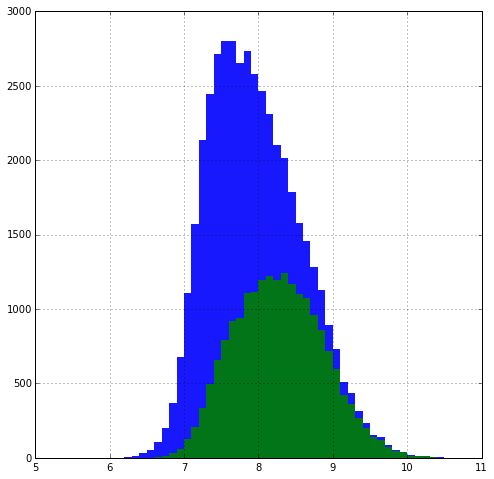

In [21]:
# ==== quantified vs identified
print len(data[data.peptide != '']) *1./ data[ic0].__len__()
data[ic0].apply(numpy.log10).median(axis=1).hist(bins=numpy.arange(5,11,0.1), lw=0, alpha=0.9)
data[data.peptide != ''][ic0].apply(numpy.log10).median(axis=1).hist(bins=numpy.arange(5,11,0.1), lw=0, alpha=0.9)
# legend(['Quantified', 'Quantified & Identified'])
# xlabel('Log10(XIC)')
# ylabel('Number of Features')
# grid(0)

In [22]:
# median-shift correction
data1 = data.copy(deep=True)
for a, b in icols:
    reg, _, _ = mediancurve(dx, 'medianEIC', b, knn=5, span=500)
    data1[a] = numpy.log2(data1[a]) - reg.predict(numpy.matrix(data1.rt).T).T[0]

In [25]:
pepdata = data1[data1.peptide != '']
# remove duplications
pepdata.drop_duplicates(subset=['uniq'], inplace=True)
# convert back to linear intensity space
pepdata[ic0] = 2 ** pepdata[ic0]

C:\Users\ZHANGBO\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\util\decorators.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
C:\Users\ZHANGBO\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\core\frame.py:2142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [26]:
pepdata

,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_01.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_02.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_03.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_04.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_01.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_02.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_03.featureXML,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_04.featureXML,20130510_EXQ1_IgPa_QC_UPS1_01.mzML_int_1,20130510_EXQ1_IgPa_QC_UPS1_02.mzML_int_1,...,BaseSeq,uniq,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_01.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_02.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_03.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS1_04.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_01.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_02.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_03.featureXML_,D:\MaxLFQ_UPS\Analysis\Quant\TOPPAS_out\011-IDMapper-out\20130510_EXQ1_IgPa_QC_UPS2_04.featureXML_
2,3.326333e+08,2.447990e+08,2.655639e+08,2.375081e+08,2.384304e+08,3.125801e+08,2.572036e+08,2.412277e+08,23.693297,24.229790,...,ALVIVESPAK,ALVIVESPAK2,27.931677,27.519600,27.196843,27.845846,27.720854,27.057058,27.207216,27.543706
5,4.067385e+09,4.165586e+09,4.095982e+09,3.954115e+09,4.011182e+09,4.122843e+09,5.419351e+09,4.685495e+09,28.356057,28.196616,...,QEAAPAAAPAPAAGVK,QEAAPAAAPAPAAGVK2,31.444349,30.916472,30.824053,30.161085,31.070770,30.231252,31.043567,30.865077
6,4.512751e+08,3.670041e+08,3.994666e+08,3.871648e+08,4.065102e+08,4.138003e+08,4.174871e+08,4.534308e+08,24.534980,24.998736,...,ALYTVVTEGK,ALYTVVTEGK2,28.928448,29.828561,28.129732,28.879880,28.927409,28.147380,28.344262,28.235668
8,1.555759e+09,1.304426e+09,1.621118e+09,1.335949e+09,1.233327e+09,1.600343e+09,1.384465e+09,1.476639e+09,0.000000,0.000000,...,ALVDAELAR,ALVDAELAR2,0.000000,0.000000,0.000000,28.987998,30.306744,0.000000,29.551396,0.000000
10,4.787257e+08,4.378805e+08,4.566312e+08,5.278484e+07,4.854192e+08,5.485156e+08,5.897121e+08,6.010129e+08,25.873852,25.830099,...,QNLAQVER,QNLAQVER2,29.465608,28.507090,29.408099,27.921914,30.020632,28.505961,29.045851,29.011266
11,6.780793e+08,7.427455e+08,6.096756e+08,8.513262e+08,4.295013e+08,7.283555e+08,8.127360e+08,7.902390e+08,24.937785,25.866995,...,FGVAAGSAATLNQGTR,FGVAAGSAATLNQGTR2,29.569715,30.088371,28.529858,29.075852,29.880171,28.291697,30.403829,29.566848
13,3.151756e+09,2.642551e+09,3.509816e+09,2.945190e+09,2.418817e+09,2.921444e+08,2.772544e+09,2.860878e+09,0.000000,27.095851,...,ALNAAGFR,ALNAAGFR2,0.000000,30.291336,30.623761,30.425061,30.765078,28.542101,29.813791,30.763151
16,1.043943e+08,8.794155e+07,7.760041e+07,8.164480e+07,7.551069e+07,8.261709e+07,9.165515e+07,1.025807e+08,21.114064,0.000000,...,WVPQVFVASGDCAER,WVPQVFVASGDCAER2,26.208689,0.000000,25.112909,26.603495,0.000000,24.406280,26.876276,0.000000
18,1.974856e+08,2.149148e+08,2.119666e+08,3.060862e+08,2.641831e+08,2.227565e+08,2.439001e+08,2.826433e+08,0.000000,0.000000,...,EWAANRPELQALCTQYGELAQAGTQR,EWAANRPELQALCTQYGELAQAGTQR3,0.000000,0.000000,0.000000,28.977885,28.813770,26.131216,28.934185,27.593812
21,1.224780e+09,2.319092e+09,2.037115e+09,1.002438e+08,2.248078e+09,2.162178e+09,3.410544e+08,2.400320e+09,27.253445,27.999567,...,AAADEWDER,AAADEWDER2,30.042509,31.072287,29.635723,0.